**References:**
- dataset: https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python
- silhouette plot: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [1]:
# -- 0. import libraries -- 
import os
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
# -- 1. loading dataset --
data = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
# -- 2. data preprocessing --
data = data.drop(columns='CustomerID')
data.Gender = data.Gender.replace({'Female': 1, 'Male': 0})
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


In [5]:
# -- 3. data visualization --

# 3.1. Gender ratio:
gender_counts = data.Gender.value_counts()
fig = px.pie(gender_counts, title='Gender Ratio', values='Gender', names=['Male', 'Female'], hole=0.5)
fig.show()

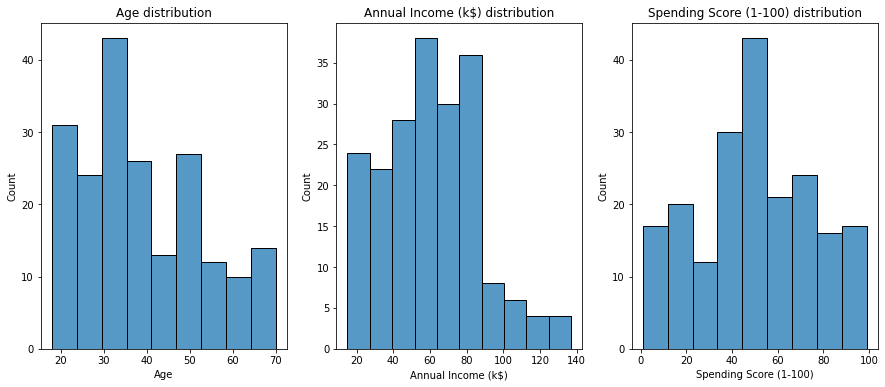

In [6]:
# 3.2. distribution of 'age', 'annual income', and 'spending score'
plt.figure(1, figsize=(15, 6))
for i, x in enumerate(['Age', 'Annual Income (k$)','Spending Score (1-100)']):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[x])
    plt.title('{} distribution'.format(x))
plt.show()

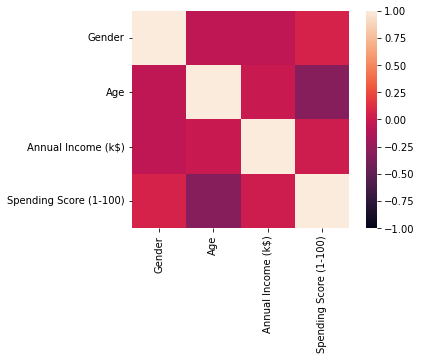

In [7]:
# 3.3. correlation matrix
sns.heatmap(data.corr(),square=True, vmax=1, vmin =-1)
plt.show()

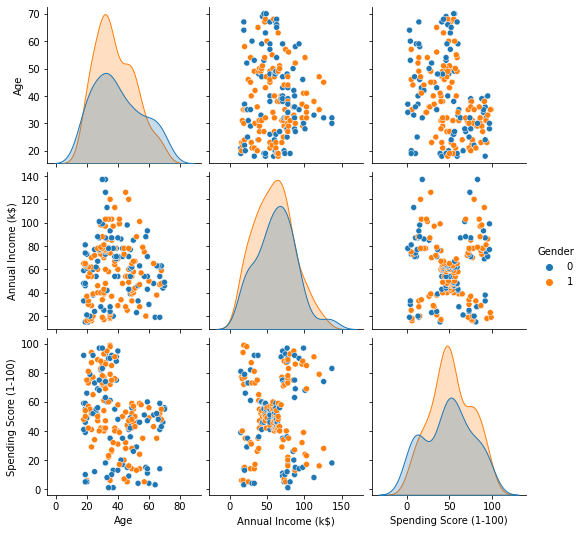

In [8]:
# 3.4. variables relationships.
sns.pairplot(data, height = 2.5, hue='Gender')
#plt.show()

In [9]:
# -- 4. scaling dataset -- 
scaler = StandardScaler()
x = scaler.fit_transform(data)

In [10]:
# plot 3d of 'age', 'annual income' and 'spending score', color is the gender.
fig = px.scatter_3d(x=x[:,1], y=x[:,2], z=x[:,3], color=x[:,0])
fig.show()

In [11]:
# for visualization purposes, I will delete the gender column, 
# but it doesn't mean that it's not important for prediction.
x = x[:,1:4]

In [12]:
# -- 4. modeling --

# -- dbscan --
model = DBSCAN(eps=0.5,min_samples=5)
cluster_labels = model.fit_predict(x)

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

Estimated number of clusters: 6
Estimated number of noise points: 60


for  6  clusters, the average silhouette score is:  0.18451372756506046


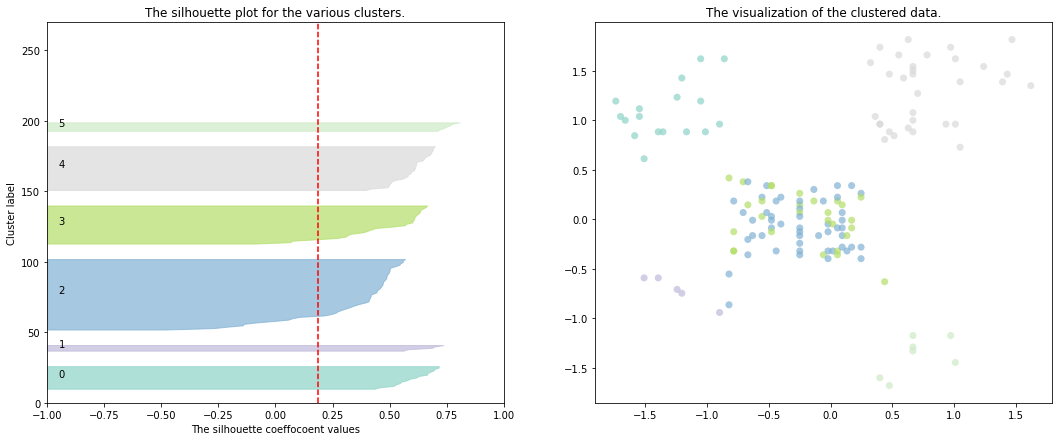

In [13]:
# -- 5. evaluating -- 
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18, 7)


# ax1 - the silhouette plot
ax1.set_xlim([-1,1])
ax1.set_ylim([0, len(x)+(n_clusters+1)*10])
silhouette_avg = silhouette_score(x, cluster_labels)
print('for ', n_clusters, ' clusters, the average silhouette score is: ',  silhouette_avg)
#silhouette score for each sample
sample_silhouette_values = silhouette_samples(x, cluster_labels)

y_lower=10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.Set3(float(i)/n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                     -1, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.95, y_lower+0.5*size_cluster_i, str(i))
    y_lower=y_upper+10
    
ax1.set_title('The silhouette plot for the various clusters.')
ax1.set_xlabel('The silhouette coeffocoent values')
ax1.set_ylabel('Cluster label')

#vertical line for the average score
ax1.axvline(x=silhouette_avg, color='red',linestyle='--')


# ax2 - the actual clusters formed
idx=np.where(cluster_labels==-1)
new_labels=np.delete(cluster_labels, idx)
new_x=np.delete(x, idx, axis=0)
colors = cm.Set3(new_labels/n_clusters)
ax2.scatter(new_x[:,1], new_x[:,2], marker='.', s=200, lw=0, alpha=0.7, c=colors, edgecolor='k')
ax2.set_title('The visualization of the clustered data.')

plt.show()

In [14]:
fig = px.scatter_3d(x=x[:,0],y=x[:,1], z=x[:,2], color=cluster_labels)
fig.show()

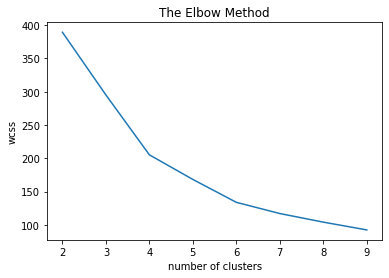

In [15]:
# -- kmean --
# now let's try kmean and see the difference.

# first we need to pick the number of clusters, according to the last elbow.
wcss=[] #within cluster sum of squares
for k in range(2,10):
    model = KMeans(n_clusters=k, init='k-means++', random_state=42)
    model.fit(x)
    wcss.append(model.inertia_)

plt.plot(range(2,10), wcss)
plt.title('The Elbow Method')
plt.xlabel('number of clusters')
plt.ylabel('wcss')
plt.show()

In [20]:
# let's pick k=6
model=KMeans(n_clusters=6, init='k-means++', random_state=42)
cluster_labels=model.fit_predict(x)

print('silhouette score is: ', silhouette_score(x, cluster_labels).round(2))
fig = px.scatter_3d(x=x[:,0],y=x[:,1], z=x[:,2], color=cluster_labels)
fig.show()

silhouette score is:  0.43


It seems that in this specific dataset kmeans gives a higher silhouette score, and produces better clusters.